In [16]:
import torch
import torchvision
import torchvision.transforms as transforms


## 1. Dataset 변경

Dataset을 MNIST에서 CIFAR10으로 변경해줍니다.

In [17]:
transform = transforms.ToTensor()

# load data to train
trainset = torchvision.datasets.CIFAR10(
    root='./data/train',
    train=True,
    download=True,
    transform=transform
)

# load data to test
testset = torchvision.datasets.CIFAR10(
    root = './data/test',
    train = False,
    download = True,
    transform = transform
)

Files already downloaded and verified
Files already downloaded and verified


## 2. CIFAR10의 입력 shape 확인
  - CIFAR10은 MNIST와 다른 입력 shape을 가지고 있습니다.
  - 입력 shape은 model을 선언할 때 중요하기 때문에 MNIST 실습 자료에서 사용한 방식과 똑같이 shape을 확인해주시면 됩니다.

In [18]:
from matplotlib import pyplot as plt

print(len(trainset)) # 50,000
print(trainset[0][0].shape, trainset[0][1])

print(len(testset)) # 10,000
print(testset[0][0].shape, testset[0][1])
# plt.imshow(trainset[0][0][0], cmap='gray')
# plt.imshow(testset[0][0][0])

50000
torch.Size([3, 32, 32]) 6
10000
torch.Size([3, 32, 32]) 3


학습 인자는 n_epochs = 50, batch_size = 256로 설정합니다.


In [19]:
batch_size = 256

# dataloader for trainset
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

# dataloader for testset
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [20]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


## 3. activation 함수 변경
Activation 함수를 nn.ReLU에서 nn.LeakyReLU로 변경해줍니다.

In [21]:
from torch import nn

l_relu = nn.LeakyReLU() # [MYCODE] LeakyReLU 선언
sigmoid = nn.Sigmoid() # [MYCODE] sigmoid 선언

In [22]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim, activation, p=0): # [MYCODE] dropout 확률을 0을 기본값으로 입력하여 별도 선언시에만 활용할 수 있도록 함
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # [MYCODE] 10개의 카테고리에 대한 classification이므로 output_dim = 10으로 설정

    self.dropout = nn.Dropout(p)
    self.act = activation

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x))) # [MYCODE] dropout을 final layer를 제외한 모든 레이어에 추가하여 모델 변경
    x = self.dropout(self.act(self.layer2(x)))
    x = self.layer3(x) # remove activation function from the final layer

    return x

In [23]:
l_relu_no_dropout_model = Model(32 * 32 * 3, 1024, l_relu).to('cuda') # [MYCODE] CIFAR10는 32 * 32 이미지면서 RGB를 표현하므로 input_dim = 32 * 32 * 3 && 1024개의 feature 추출을 위해 n_dim=1024
sigmoid_no_dropout_model = Model(32 * 32 * 3, 1024, sigmoid).to('cuda')

l_relu_dropout_model = Model(32 * 32 * 3, 1024, l_relu, 0.1).to('cuda') # [MYCODE] dropout 확률을 0.1로 설정


## 4. SGD와 Adam 성능 비교

먼저 Adam optimizer을 사용하여 학습하는 코드를 구현합니다.

(Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot합니다.

In [24]:
from torch.optim import SGD, Adam

lr = 0.001
def opt_sgd(model):
  return SGD(model.parameters(), lr=lr)

def opt_adam(model):
  return Adam(model.parameters(), lr=lr)

In [26]:
cel = nn.CrossEntropyLoss() # for classification

In [35]:
train_accs = []
test_accs = []

In [28]:
def Accuracy(train_accs, test_accs, model, loss_fn, optimizer, n_epochs=50):

  for epoch in range(n_epochs):
    train_loss = 0
    train_cnt = 0
    train_acc = 0
    test_cnt = 0
    test_acc = 0

    if not model.training:
      model.train()

    for inputs, labels in trainloader:
      model.zero_grad()
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      loss = loss_fn(preds, labels)

      preds = torch.argmax(preds, dim=1)

      train_cnt += labels.shape[0]
      train_acc += (preds == labels).sum().item()

      loss.backward()
      optimizer.step()

      train_loss += loss.item()
    train_accs.append(train_acc / train_cnt)

    model.eval()
    with torch.no_grad():
      for inputs, labels in testloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)

        preds = torch.argmax(preds, dim=1)

        test_cnt += labels.shape[0]
        test_acc += (preds == labels).sum().item()

      test_accs.append(test_acc / test_cnt)

    #print(f"Epoch {epoch:3d} | Train Loss: {train_loss}")

In [30]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

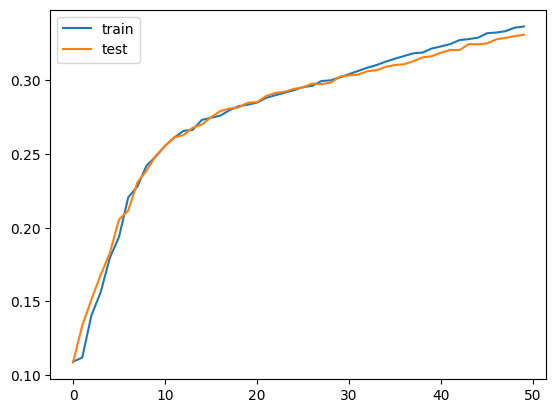

In [31]:
Accuracy(train_accs, test_accs, l_relu_no_dropout_model, cel, opt_sgd(l_relu_no_dropout_model))
plot_acc(train_accs, test_accs)
train_accs, test_accs = [], []

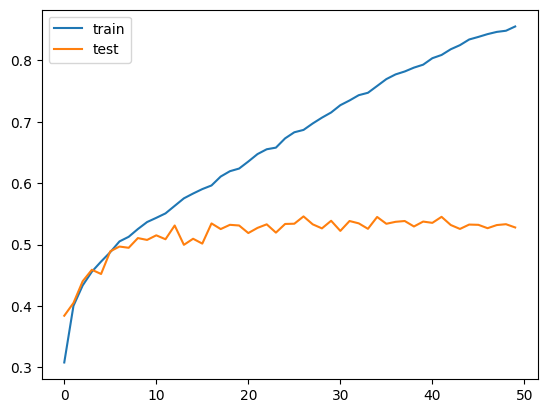

In [32]:
Accuracy(train_accs, test_accs, l_relu_no_dropout_model, cel, opt_adam(l_relu_no_dropout_model))
plot_acc(train_accs, test_accs)
train_accs, test_accs = [], []

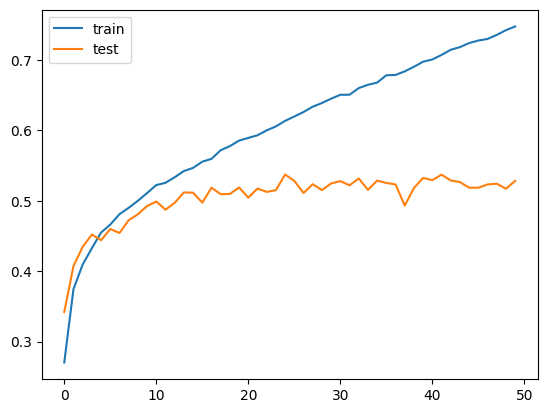

In [33]:
Accuracy(train_accs, test_accs, sigmoid_no_dropout_model, cel, opt_adam(sigmoid_no_dropout_model))
plot_acc(train_accs, test_accs)
train_accs, test_accs = [], []

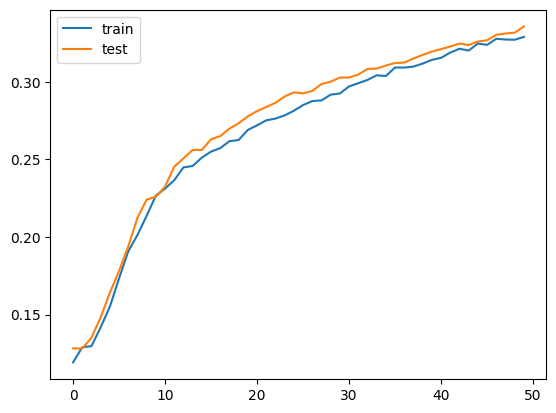

In [34]:
Accuracy(train_accs, test_accs, l_relu_dropout_model, cel, opt_sgd(l_relu_dropout_model))
plot_acc(train_accs, test_accs)
train_accs, test_accs = [], []